In [1]:
import pandas as pd
import numpy as np
import time
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report, roc_auc_score 
from sklearn.metrics import f1_score, average_precision_score, recall_score, ConfusionMatrixDisplay
from scipy.io import arff
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

## Obesity Levels

In [2]:
# Cargamos el dataset (ajusta la ruta si es necesario)

df = pd.read_csv("Obesity_Levels/ObesityDataSet.csv")

# Revisamos las primeras filas del dataset
display(df.head())
print("Valores faltantes: ", df.isna().sum().sum())

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


Valores faltantes:  0


In [3]:
# Codificación de las variables categóricas
le = LabelEncoder()
categorical_columns = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

label_encoder = LabelEncoder()
df['NObeyesdad'] = label_encoder.fit_transform(df['NObeyesdad'])

display(df)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,21.000000,1.620000,64.000000,1,0,2.0,3.0,2,0,2.000000,0,0.000000,1.000000,3,3,1
1,0,21.000000,1.520000,56.000000,1,0,3.0,3.0,2,1,3.000000,1,3.000000,0.000000,2,3,1
2,1,23.000000,1.800000,77.000000,1,0,2.0,3.0,2,0,2.000000,0,2.000000,1.000000,1,3,1
3,1,27.000000,1.800000,87.000000,0,0,3.0,3.0,2,0,2.000000,0,2.000000,0.000000,1,4,5
4,1,22.000000,1.780000,89.800000,0,0,2.0,1.0,2,0,2.000000,0,0.000000,0.000000,2,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0,20.976842,1.710730,131.408528,1,1,3.0,3.0,2,0,1.728139,0,1.676269,0.906247,2,3,4
2107,0,21.982942,1.748584,133.742943,1,1,3.0,3.0,2,0,2.005130,0,1.341390,0.599270,2,3,4
2108,0,22.524036,1.752206,133.689352,1,1,3.0,3.0,2,0,2.054193,0,1.414209,0.646288,2,3,4
2109,0,24.361936,1.739450,133.346641,1,1,3.0,3.0,2,0,2.852339,0,1.139107,0.586035,2,3,4


#### Entrenamiento

In [4]:
# Separar las características y la variable objetivo
y = df['NObeyesdad']
X = df.drop(columns=['NObeyesdad'])  # NObeyesdad es la variable de nivel de obesidad

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# 3. Búsqueda de hiperparámetros con GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(objective="multi:softmax", num_class=7),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1
)

start_time = time.time()
print("\nIniciando búsqueda de hiperparámetros...")
grid_search.fit(X_train, y_train)

print("\nMejores hiperparámetros:", grid_search.best_params_)

# 4. Entrenamiento del modelo con los mejores hiperparámetros
best_model = grid_search.best_estimator_


training_time = time.time() - start_time
# Imprimir el tiempo de entrenamiento en segundos
print("Tiempo de entrenamiento: %.4f segundos" % training_time)


Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 972 candidates, totalling 4860 fits

Mejores hiperparámetros: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Tiempo de entrenamiento: 2355.6873 segundos


In [6]:
# Predicciones
y_pred = best_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred)
print("Accuracy de XGBoost: ", round(accuracy_xgb,3))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy de XGBoost:  0.957
                     precision    recall  f1-score   support

Insufficient_Weight       0.93      1.00      0.97        56
      Normal_Weight       0.95      0.87      0.91        62
     Obesity_Type_I       0.99      0.95      0.97        78
    Obesity_Type_II       0.97      0.98      0.97        58
   Obesity_Type_III       1.00      1.00      1.00        63
 Overweight_Level_I       0.88      0.93      0.90        56
Overweight_Level_II       0.98      0.98      0.98        50

           accuracy                           0.96       423
          macro avg       0.96      0.96      0.96       423
       weighted avg       0.96      0.96      0.96       423



In [7]:
y_pred = best_model.predict(X_test)

# Métricas
print("\nAccuracy del modelo:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred, average='weighted')
test_precision = precision_score(y_test, y_pred, average='weighted')
test_recall = recall_score(y_test, y_pred, average='weighted')

print(f"Test Accuracy: {test_accuracy*100:.2f}")
print(f"Test F1-score: {test_f1*100:.2f}")
print(f"Test Precision: {test_precision*100:.2f}")
print(f"Test Recall: {test_recall*100:.2f}")


Accuracy del modelo: 0.9574468085106383

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        56
           1       0.95      0.87      0.91        62
           2       0.99      0.95      0.97        78
           3       0.97      0.98      0.97        58
           4       1.00      1.00      1.00        63
           5       0.88      0.93      0.90        56
           6       0.98      0.98      0.98        50

    accuracy                           0.96       423
   macro avg       0.96      0.96      0.96       423
weighted avg       0.96      0.96      0.96       423

Test Accuracy: 95.74
Test F1-score: 95.73
Test Precision: 95.83
Test Recall: 95.74


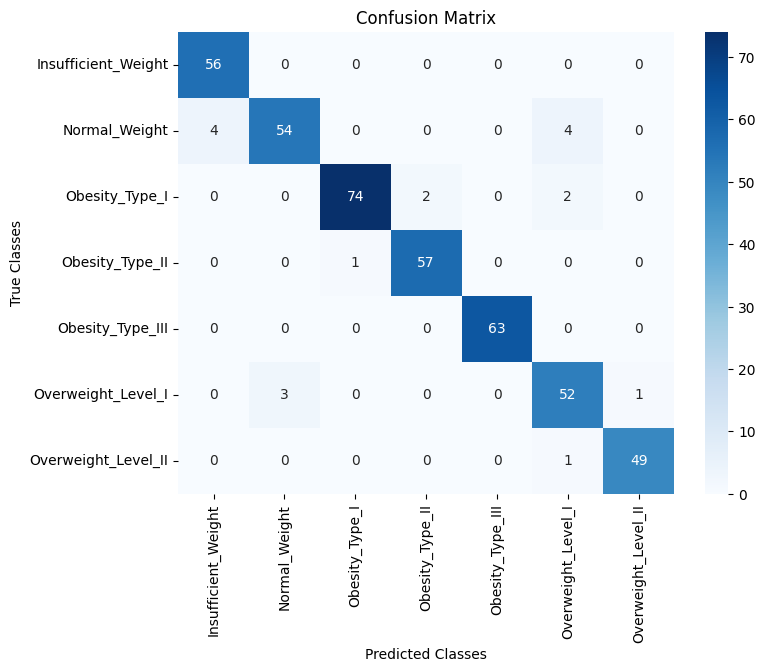

In [8]:
conf_matrix = confusion_matrix(y_test, y_pred)
# Visualización
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.title('Confusion Matrix')
plt.show()

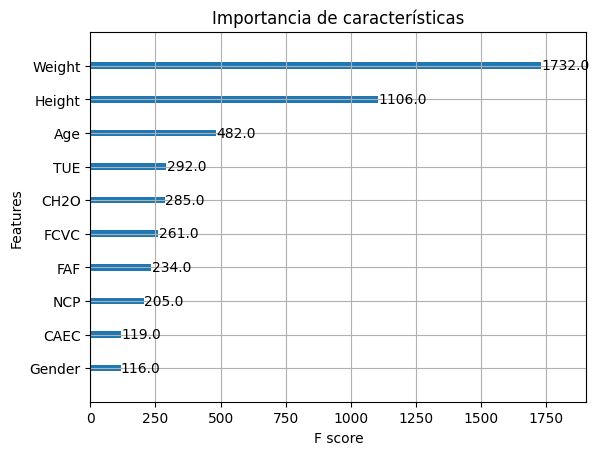

In [9]:
# Importancia de las características
xgb.plot_importance(best_model, importance_type='weight', max_num_features=10)
plt.title("Importancia de características")
plt.show()

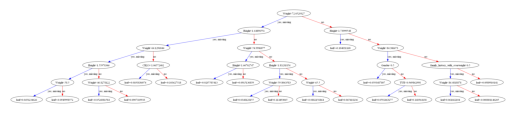

In [10]:
xgb.plot_tree(best_model, num_trees=best_model.best_iteration)

# Guarda el gráfico como un archivo PNG
plt.savefig("tree_plot.png", dpi=600, bbox_inches='tight')

# Opcionalmente, muestra el gráfico (puede ser muy grande)
plt.show()

## Bone Marrow Transplant

#### Entrenamiento 1

In [25]:
dataRff = arff.loadarff('Bone_Marrow_Transplant/bone-marrow.arff')
df = pd.DataFrame(dataRff[0])
df.survival_status = df.survival_status.astype(int)

df.drop(columns='survival_time', inplace=True)

# Decodificar las columnas binarias o categóricas que están en bytes
for column in df.select_dtypes([object]).columns:
    # Convertir las columnas de bytes a strings (y opcionalmente a enteros si son 0/1)
    df[column] = df[column].str.decode('utf-8')  # Para texto

for i in range(len(df)):
    for col in df:
        if df[col].dtype == np.dtype('object'):
            if df.at[i, col] == '?':
                df.at[i, col] = np.nan
        else:
            if pd.isna(df.loc[i, col]):
                df.at[i, col] = np.nan


# Codificación de variables categóricas
cat_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [26]:
# Separar variables predictoras y objetivo
y = df['survival_status']  # Cambia según el nombre de la columna objetivo
X = df.drop(['survival_status'], axis=1)

# División del dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identificar columnas numéricas
NUMERIC_FEATURES = X_train.select_dtypes(include=['float64', 'int64']).columns

# Crear el pipeline para las columnas numéricas
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

numeric_pipe = Pipeline([
    ('impute', imputer),
    ('scale', scaler),
])

# Ajustar el pipeline solo con los datos de entrenamiento
numeric_pipe.fit(X_train[NUMERIC_FEATURES])

# Transformar los datos de entrenamiento y prueba
X_train[NUMERIC_FEATURES] = numeric_pipe.transform(X_train[NUMERIC_FEATURES])
X_test[NUMERIC_FEATURES] = numeric_pipe.transform(X_test[NUMERIC_FEATURES])

# 3. Búsqueda de hiperparámetros con GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(random_state=123, objective="binary:logistic"),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5
)

start_time = time.time()
print("\nIniciando búsqueda de hiperparámetros...")
grid_search.fit(X_train, y_train)

print("\nMejores hiperparámetros:", grid_search.best_params_)

# 4. Entrenamiento del modelo con los mejores hiperparámetros
best_model = grid_search.best_estimator_


training_time = time.time() - start_time

# Imprimir el tiempo de entrenamiento en segundos
print("Tiempo de entrenamiento: %.4f segundos" % training_time)


Iniciando búsqueda de hiperparámetros...

Mejores hiperparámetros: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Tiempo de entrenamiento: 353.0087 segundos


In [27]:
# Predicciones

y_pred = best_model.predict(X_test)

# Métricas
print("\nAccuracy del modelo:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

print("Accuracy: ", round(accuracy_score(y_test, y_pred),4)*100)
print("ROC AUC:", np.round(roc_auc_score(y_test, y_pred), 4)*100)
print("PR AUC:", np.round(average_precision_score(y_test, y_pred), 4)*100)
print("F1-score:", np.round(f1_score(y_test, y_pred), 4)*100)
print("Precision:", np.round(precision_score(y_test, y_pred), 4)*100)
print("Recall:", np.round(recall_score(y_test, y_pred), 4)*100)


Accuracy del modelo: 0.8157894736842105

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85        22
           1       0.85      0.69      0.76        16

    accuracy                           0.82        38
   macro avg       0.82      0.80      0.80        38
weighted avg       0.82      0.82      0.81        38

Accuracy:  81.58
ROC AUC: 79.83
PR AUC: 71.33
F1-score: 75.86
Precision: 84.61999999999999
Recall: 68.75



Matriz de confusión:


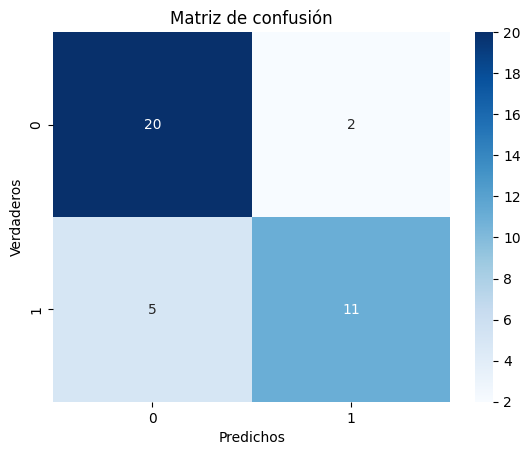

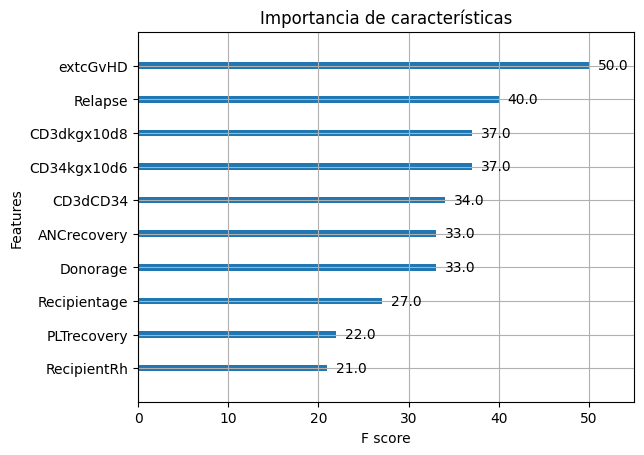

In [28]:
print("\nMatriz de confusión:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Verdaderos')
plt.xlabel('Predichos')
plt.title('Matriz de confusión')
plt.show()

# Importancia de las características
xgb.plot_importance(best_model, importance_type='weight', max_num_features=10)
plt.title("Importancia de características")
plt.show()


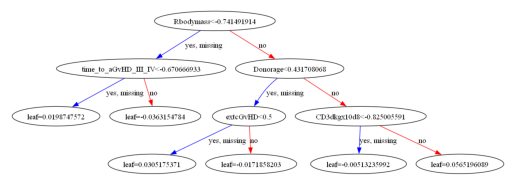

In [29]:
xgb.plot_tree(best_model, num_trees=best_model.best_iteration)

# Guarda el gráfico como un archivo PNG
plt.savefig("tree_plot.png", dpi=600, bbox_inches='tight')

# Opcionalmente, muestra el gráfico (puede ser muy grande)
plt.show()

## Chronic Kidney Disease

In [2]:
df = pd.read_csv('Chronic_Kidney_Disease/kidney_disease.csv')

df.drop(columns='id', inplace=True)

df = df.replace(r' ', '', regex=True)
df = df.replace(r'\t', '', regex=True)
for i in range(len(df)):
    for col in df:
        if df[col].dtype == np.dtype('object'):
            if df.at[i, col] == '?':
                df.at[i, col] = np.nan
        else:
            if pd.isna(df.loc[i, col]):
                df.at[i, col] = np.nan

# print(df.isna().sum().sum())

display(df)

df.dtypes

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35,7300,4.6,no,no,no,good,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,...,47,6700,4.9,no,no,no,good,no,no,notckd
396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,...,54,7800,6.2,no,no,no,good,no,no,notckd
397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,...,49,6600,5.4,no,no,no,good,no,no,notckd
398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,...,51,7200,5.9,no,no,no,good,no,no,notckd


age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv                object
wc                 object
rc                 object
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object

In [3]:
df['classification'] = df['classification'].map({'ckd': 0, 'notckd': 1})

In [4]:
cat_col=[col for col in df.columns if df[col].dtype =='object'] # categoric
num_col=[col for col in df.columns if df[col].dtype !='object'] # numeric

In [6]:
def solve_mv_mode(feature):
    mode=df[feature].mode()[0]
    df[feature]=df[feature].fillna(mode)
    
for col in cat_col:
    solve_mv_mode(col)
df[cat_col].isna().sum()

rbc      0
pc       0
pcc      0
ba       0
pcv      0
wc       0
rc       0
htn      0
dm       0
cad      0
appet    0
pe       0
ane      0
dtype: int64

In [7]:
encoder=LabelEncoder()
for col in cat_col:
    df[col]=encoder.fit_transform(df[col])

In [8]:
X = df.drop(columns= ['classification'])
Y = df['classification']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# Identificar columnas numéricas
NUMERIC_FEATURES = X_train.select_dtypes(include=['float64', 'int64']).columns

# Crear el pipeline para las columnas numéricas
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

numeric_pipe = Pipeline([
    ('impute', imputer),
    ('scale', scaler),
])

# Ajustar el pipeline solo con los datos de entrenamiento
numeric_pipe.fit(X_train[NUMERIC_FEATURES])

# Transformar los datos de entrenamiento y prueba
X_train[NUMERIC_FEATURES] = numeric_pipe.transform(X_train[NUMERIC_FEATURES])
X_test[NUMERIC_FEATURES] = numeric_pipe.transform(X_test[NUMERIC_FEATURES])

# 3. Búsqueda de hiperparámetros con GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(objective="binary:logistic",random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1
)

start_time = time.time()
print("\nIniciando búsqueda de hiperparámetros...")
grid_search.fit(X_train, y_train)

print("\nMejores hiperparámetros:", grid_search.best_params_)

# 4. Entrenamiento del modelo con los mejores hiperparámetros
best_model = grid_search.best_estimator_


training_time = time.time() - start_time

# Imprimir el tiempo de entrenamiento en segundos
print("Tiempo de entrenamiento: %.4f segundos" % training_time)


Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 972 candidates, totalling 4860 fits

Mejores hiperparámetros: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 0.8}
Tiempo de entrenamiento: 437.8093 segundos


In [11]:
# Predicciones
y_pred = best_model.predict(X_test)
# Métricas
print("\nAccuracy del modelo:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


Accuracy del modelo: 0.9875

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        52
           1       0.97      1.00      0.98        28

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



In [13]:
print("Accuracy: ", round(accuracy_score(y_test, y_pred),4)*100)
print("ROC AUC:", np.round(roc_auc_score(y_test, y_pred), 4)*100)
print("PR AUC:", np.round(average_precision_score(y_test, y_pred), 4)*100)
print("F1-score:", np.round(f1_score(y_test, y_pred), 4)*100)
print("Precision:", np.round(precision_score(y_test, y_pred), 4)*100)
print("Recall:", np.round(recall_score(y_test, y_pred), 4)*100)

Accuracy:  98.75
ROC AUC: 99.03999999999999
PR AUC: 96.55
F1-score: 98.25
Precision: 96.55
Recall: 100.0


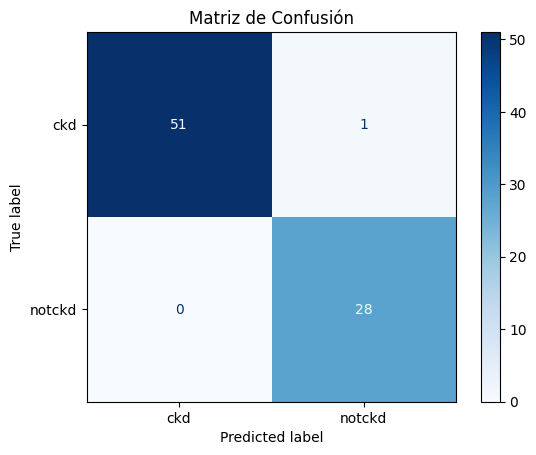

In [15]:
import matplotlib.pyplot as plt

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Definir las etiquetas personalizadas
labels = ['ckd', 'notckd']

# Mostrar la matriz de confusión con etiquetas personalizadas
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

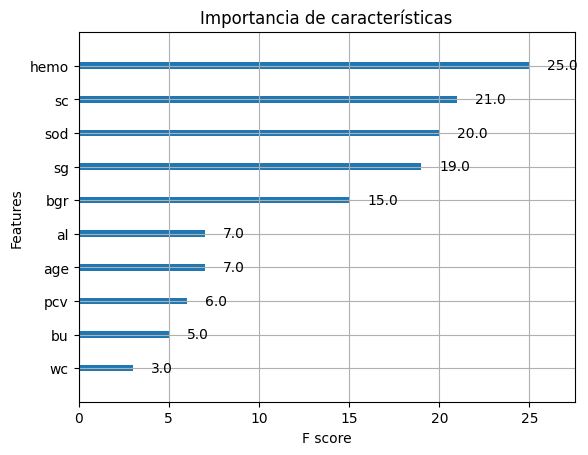

In [15]:
# Importancia de las características
xgb.plot_importance(best_model, importance_type='weight', max_num_features=10)
plt.title("Importancia de características")
plt.show()

<AxesSubplot:>

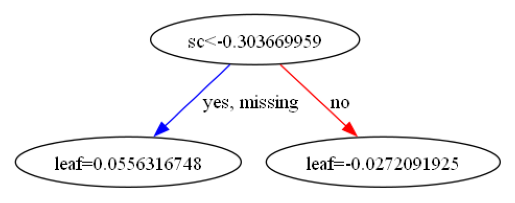

In [16]:
xgb.plot_tree(best_model, num_trees=best_model.best_iteration)

## Diabetes 130-US Hospitals

In [12]:
df = pd.read_csv('Diabetes_130US/diabetic_data.csv')

df.loc[df['race'] == '?', 'race'] = 'Other'

df.drop(df[df['gender'] == 'Unknown/Invalid'].index, inplace = True)

df.reset_index(inplace = True, drop = True)

df.drop(columns = ['weight', 'payer_code', 'medical_specialty'], inplace = True)

df.drop(columns = ['acetohexamide', 'tolbutamide', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
                   'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
                   'metformin-pioglitazone'], inplace = True)

df = df[~((df['diag_1'] == "?") | (df['diag_2'] == "?") | (df['diag_3'] == "?"))]

df = df.drop(columns= ['encounter_id', 'patient_nbr'])

df, _ = train_test_split(
    df, 
    test_size=0.95,  # Retenemos solo el 15%
    stratify=df['readmitted'],  # Balanceamos en función de la columna 'race'
    random_state=42  # Para reproducibilidad
)

df['readmitted']=df['readmitted'].apply(lambda x : 1 if x =='<30' or x == '>30' else 0)

#### Transform Categorical Features

In [13]:
categorical_features =['race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin',
       'glyburide-metformin', 'change', 'diabetesMed', 'max_glu_serum', 'A1Cresult'] 

le = LabelEncoder()
for i in categorical_features:
    df[i] = le.fit_transform(df[i])

In [14]:
X = df.drop(columns= ['readmitted'])
y = df['readmitted']

In [16]:
df.shape

(5012, 35)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# 3. Búsqueda de hiperparámetros con GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(objective="binary:logistic",random_state=42, eval_metric='logloss'),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1
)

start_time = time.time()
print("\nIniciando búsqueda de hiperparámetros...")
grid_search.fit(X_train, y_train)

print("\nMejores hiperparámetros:", grid_search.best_params_)

# 4. Entrenamiento del modelo con los mejores hiperparámetros
best_model = grid_search.best_estimator_

training_time = time.time() - start_time
# Imprimir el tiempo de entrenamiento en segundos
print("Tiempo de entrenamiento: %.4f segundos" % training_time)


Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 972 candidates, totalling 4860 fits

Mejores hiperparámetros: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}
Tiempo de entrenamiento: 1117.5578 segundos


In [18]:
# Predicciones

y_pred = best_model.predict(X_test)
print("Accuracy: ", round(accuracy_score(y_test, y_pred),4)*100)
print("ROC AUC:", np.round(roc_auc_score(y_test, y_pred), 4)*100)
print("PR AUC:", np.round(average_precision_score(y_test, y_pred), 4)*100)
print("F1-score:", np.round(f1_score(y_test, y_pred), 4)*100)
print("Precision:", np.round(precision_score(y_test, y_pred), 4)*100)
print("Recall:", np.round(recall_score(y_test, y_pred), 4)*100)

# Métricas
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

Accuracy:  64.81
ROC AUC: 63.2
PR AUC: 54.52
F1-score: 54.56999999999999
Precision: 65.23
Recall: 46.9

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.65      0.79      0.71       551
           1       0.65      0.47      0.55       452

    accuracy                           0.65      1003
   macro avg       0.65      0.63      0.63      1003
weighted avg       0.65      0.65      0.64      1003



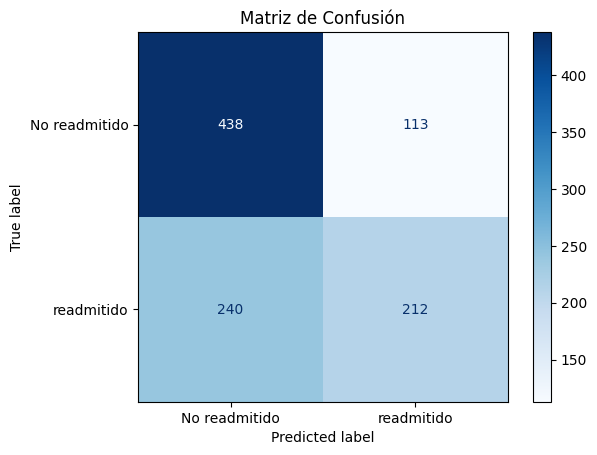

In [20]:
import matplotlib.pyplot as plt

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión
# Definir las etiquetas personalizadas
labels = ['No readmitido', 'readmitido']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

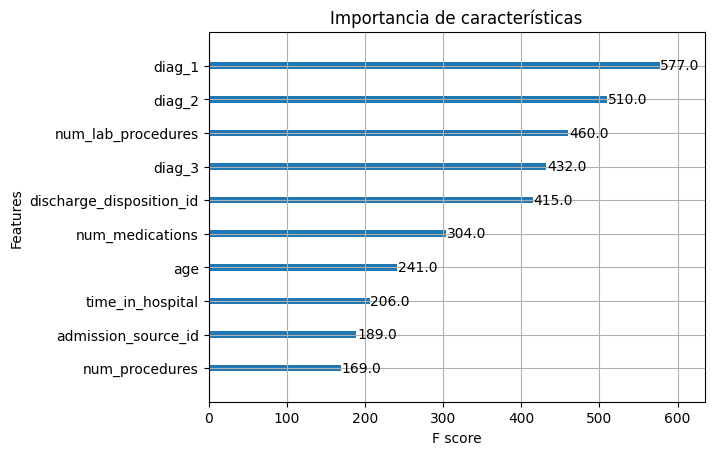

In [24]:
# Importancia de las características
xgb.plot_importance(best_model, importance_type='weight', max_num_features=10)
plt.title("Importancia de características")
plt.show()

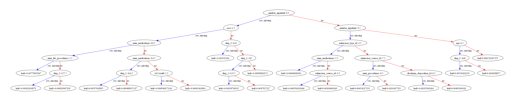

In [22]:
xgb.plot_tree(best_model, num_trees=best_model.best_iteration)

# Guarda el gráfico como un archivo PNG
plt.savefig("tree_plot.png", dpi=600, bbox_inches='tight')

# Opcionalmente, muestra el gráfico (puede ser muy grande)
plt.show()